In [ ]:
import numpy as np # For computations of probabilities, perplexities and expected count
import pandas as pd # For transforming JSON data into a pandas dataframe
import nltk # Used for tokenization of training and testing set
from nltk import pos_tag # Used for parts of speech (POS) tagging
from tqdm import tqdm # For displaying progress bar
from sklearn.preprocessing import OneHotEncoder # Used for converting extracted features to vectors
from sklearn.model_selection import train_test_split # Used to split training and testing set
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer, sent_tokenize
from typing import Iterator
from collections import Counter
from nltk import ngrams
import ollama

In [ ]:
# B.1.1: Define the maximum length for a sequence
MAX_LEN = 40


# B.1.4: CSV path
csv_path = (r'C:\Users\Jeryl Salas\OneDrive\Documents\AI Work\TaskEstimator\CLEANED_ONE_HOT_developers_estimation_data_july_24_hour_09.csv')

# B.1.5: Load the dataset from CSV
df = pd.read_csv(csv_path)

In [ ]:
# Convert one hot encoding to just one column (Wasn't able to use in this instance)
start_col_idx = 10
job_position_columns = df.columns[start_col_idx:]
processed_columns = job_position_columns.str.replace('Job Position: ', '')
df.rename(columns=dict(zip(job_position_columns, processed_columns)), inplace=True)
def get_job_position(row):
    return row.idxmax()
df['Job Position'] = df.iloc[:, start_col_idx:].apply(get_job_position, axis=1)
pd.set_option('display.max_columns', None)
print(df[:10])


# Display train and test num rows
print(f'No. of rows: {len(df)}')

                                           task_name  task_actual_hours  \
0  Automation | Time/Money: Timelogs | Viewing of...          12.228154   
1  OPF: Org/Workforce Executive - Memorandums: No...           0.772654   
2  OPF: Org Executive: Breach of Contract Amount ...           0.000000   
3  OPF: Issues-Card: Unable to create a card if n...           1.351673   
4  OPF: Issues - Card Creation Modal - All Member...           0.000000   
5  OPF: Log out: Infinite loading when logging ou...           1.461769   
6  OPF: Requests: Rejecting a request: CapsLock w...           0.000000   
7  OPF: Org Exec/Manager/Supervisor - Tags: Add E...           9.542893   
8      OPF: Employment - 201 Files: Cannot Upload ID           0.001749   
9        [ScalemaAI] - FE - Chat Feed Implementation          27.795517   

   estimation_hours                employee_name  years_of_experience  \
0              12.0                Lydia Karungi                    3   
1              16.0  Osho Ga

In [ ]:
# Frequency distribution of 'task_actual_hours'
frequency_distribution = df['task_actual_hours'].value_counts().sort_index()

# Display the result
print(frequency_distribution)

task_actual_hours
0.000000      188
0.000566        1
0.001749        1
0.002852        1
0.078889        1
             ... 
92.579199       1
93.171799       1
95.726318       1
296.955904      1
373.817086      1
Name: count, Length: 4142, dtype: int64


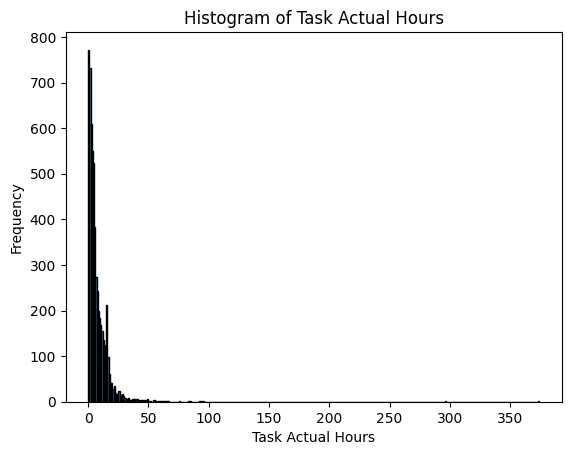

In [ ]:
import matplotlib.pyplot as plt

# Plot histogram of 'task_actual_hours' from 0 to the maximum value
plt.hist(df['task_actual_hours'], bins=range(0, int(df['task_actual_hours'].max()) + 2), edgecolor='black')

# Add labels and title
plt.xlabel('Task Actual Hours')
plt.ylabel('Frequency')
plt.title('Histogram of Task Actual Hours')

# Show the plot
plt.show()

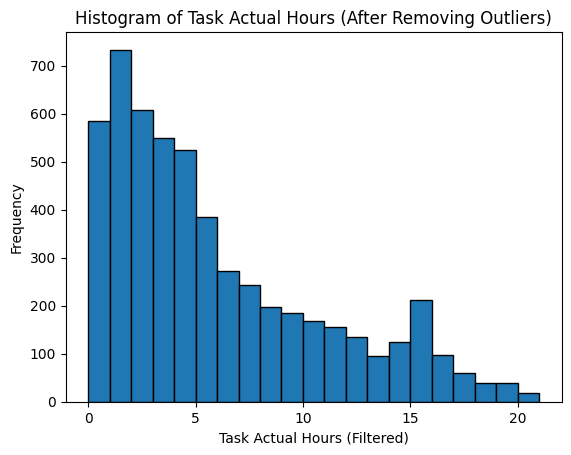

In [ ]:
# Remove values greater than the 95th percentile
upper_limit = df['task_actual_hours'].quantile(0.95)
df_filtered = df[(df['task_actual_hours'] <= upper_limit) & (df['task_actual_hours'] > 0)]

# Plot the histogram after filtering out outliers
plt.hist(df_filtered['task_actual_hours'], bins=range(0, int(df_filtered['task_actual_hours'].max()) + 2), edgecolor='black')

# Add labels and title
plt.xlabel('Task Actual Hours (Filtered)')
plt.ylabel('Frequency')
plt.title('Histogram of Task Actual Hours (After Removing Outliers)')

# Show the plot
plt.show()


In [ ]:
# Number of rows before and after filtering
original_count = len(df)
filtered_count = len(df_filtered)

# Calculate how many were filtered out
filtered_out_count = original_count - filtered_count

# Display the result
print(f"Original count: {original_count}")
print(f"Filtered count: {filtered_count}")
print(f"Number of rows filtered out: {filtered_out_count}")


Original count: 5911
Filtered count: 5427
Number of rows filtered out: 484


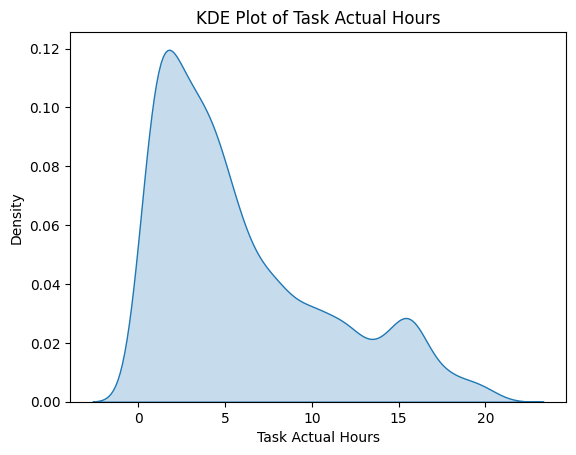

In [ ]:
import seaborn as sns

# Plot KDE for task_actual_hours
sns.kdeplot(df_filtered['task_actual_hours'], fill=True)

# Add labels and title
plt.xlabel('Task Actual Hours')
plt.ylabel('Density')
plt.title('KDE Plot of Task Actual Hours')

# Show the plot
plt.show()


In [ ]:
df = df_filtered

In [ ]:
import torch
print(torch.cuda.is_available())

True


In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from datasets import Dataset
import torch
import pandas as pd

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using device: {device}")

# Load Pre-trained BERT and tokenizer
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=1)  # Regression head
model.to(device)


# df -> dataset
dataset = Dataset.from_pandas(df[['task_name', 'task_actual_hours']])

# Tokenize
def tokenize(batch):
    return tokenizer(batch["task_name"], padding="max_length", truncation=True)

encoded_dataset = dataset.map(tokenize, batched=True)

# Column Rename
encoded_dataset = encoded_dataset.rename_column("task_actual_hours", "labels")

# Training Params
training_args = TrainingArguments(
    output_dir="./bert-task-regressor",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    logging_dir="./logs",
    logging_steps=10,
    report_to="none",
)

# Fine-tuning with trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset,
    eval_dataset=encoded_dataset,
)

trainer.train()

# Model Saved
model.save_pretrained("./bert-task-regressor")
tokenizer.save_pretrained("./bert-task-regressor")


c:\Users\Jeryl Salas\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/5427 [00:00<?, ? examples/s]

c:\Users\Jeryl Salas\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/3395 [00:00<?, ?it/s]

{'loss': 45.8759, 'grad_norm': 230.15188598632812, 'learning_rate': 1.9941089837997055e-05, 'epoch': 0.01}
{'loss': 38.2123, 'grad_norm': 208.5812225341797, 'learning_rate': 1.9882179675994112e-05, 'epoch': 0.03}
{'loss': 22.5234, 'grad_norm': 71.24597930908203, 'learning_rate': 1.9823269513991165e-05, 'epoch': 0.04}
{'loss': 29.9385, 'grad_norm': 111.69676208496094, 'learning_rate': 1.9764359351988222e-05, 'epoch': 0.06}
{'loss': 30.3008, 'grad_norm': 31.366901397705078, 'learning_rate': 1.9705449189985275e-05, 'epoch': 0.07}
{'loss': 25.4056, 'grad_norm': 38.54899597167969, 'learning_rate': 1.964653902798233e-05, 'epoch': 0.09}
{'loss': 20.7922, 'grad_norm': 42.947994232177734, 'learning_rate': 1.9587628865979382e-05, 'epoch': 0.1}
{'loss': 21.7028, 'grad_norm': 84.5381088256836, 'learning_rate': 1.9528718703976436e-05, 'epoch': 0.12}
{'loss': 28.4945, 'grad_norm': 71.6004638671875, 'learning_rate': 1.9469808541973492e-05, 'epoch': 0.13}
{'loss': 25.2741, 'grad_norm': 57.428485870361

  0%|          | 0/679 [00:00<?, ?it/s]

{'eval_loss': 18.341745376586914, 'eval_runtime': 1213.4089, 'eval_samples_per_second': 4.473, 'eval_steps_per_second': 0.56, 'epoch': 1.0}
{'loss': 20.3057, 'grad_norm': 183.62619018554688, 'learning_rate': 1.5994108983799707e-05, 'epoch': 1.0}
{'loss': 18.943, 'grad_norm': 259.0528564453125, 'learning_rate': 1.593519882179676e-05, 'epoch': 1.02}
{'loss': 21.505, 'grad_norm': 77.38935852050781, 'learning_rate': 1.5876288659793813e-05, 'epoch': 1.03}
{'loss': 22.491, 'grad_norm': 189.78912353515625, 'learning_rate': 1.581737849779087e-05, 'epoch': 1.05}
{'loss': 21.4017, 'grad_norm': 154.40518188476562, 'learning_rate': 1.5758468335787924e-05, 'epoch': 1.06}
{'loss': 12.3136, 'grad_norm': 182.6218719482422, 'learning_rate': 1.569955817378498e-05, 'epoch': 1.08}
{'loss': 22.3519, 'grad_norm': 56.095985412597656, 'learning_rate': 1.5640648011782034e-05, 'epoch': 1.09}
{'loss': 23.2418, 'grad_norm': 412.662353515625, 'learning_rate': 1.5581737849779087e-05, 'epoch': 1.1}
{'loss': 21.3654,

  0%|          | 0/679 [00:00<?, ?it/s]

{'eval_loss': 14.367278099060059, 'eval_runtime': 1087.0309, 'eval_samples_per_second': 4.992, 'eval_steps_per_second': 0.625, 'epoch': 2.0}
{'loss': 9.2188, 'grad_norm': 110.3945083618164, 'learning_rate': 1.1988217967599412e-05, 'epoch': 2.0}
{'loss': 12.9105, 'grad_norm': 136.09762573242188, 'learning_rate': 1.1929307805596467e-05, 'epoch': 2.02}
{'loss': 17.4971, 'grad_norm': 239.92214965820312, 'learning_rate': 1.187039764359352e-05, 'epoch': 2.03}
{'loss': 17.9218, 'grad_norm': 184.88037109375, 'learning_rate': 1.1811487481590575e-05, 'epoch': 2.05}
{'loss': 15.3451, 'grad_norm': 643.4564819335938, 'learning_rate': 1.175257731958763e-05, 'epoch': 2.06}
{'loss': 14.3982, 'grad_norm': 878.3031616210938, 'learning_rate': 1.1693667157584685e-05, 'epoch': 2.08}
{'loss': 11.9715, 'grad_norm': 380.0533752441406, 'learning_rate': 1.163475699558174e-05, 'epoch': 2.09}
{'loss': 13.6874, 'grad_norm': 149.3000946044922, 'learning_rate': 1.1575846833578794e-05, 'epoch': 2.11}
{'loss': 18.7417

  0%|          | 0/679 [00:00<?, ?it/s]

{'eval_loss': 10.615904808044434, 'eval_runtime': 1082.4039, 'eval_samples_per_second': 5.014, 'eval_steps_per_second': 0.627, 'epoch': 3.0}
{'loss': 22.4295, 'grad_norm': 201.3023223876953, 'learning_rate': 7.982326951399117e-06, 'epoch': 3.0}
{'loss': 10.1764, 'grad_norm': 381.3646240234375, 'learning_rate': 7.923416789396172e-06, 'epoch': 3.02}
{'loss': 9.3, 'grad_norm': 244.1008758544922, 'learning_rate': 7.864506627393225e-06, 'epoch': 3.03}
{'loss': 10.3904, 'grad_norm': 405.39666748046875, 'learning_rate': 7.80559646539028e-06, 'epoch': 3.05}
{'loss': 9.5531, 'grad_norm': 472.5354309082031, 'learning_rate': 7.746686303387335e-06, 'epoch': 3.06}
{'loss': 6.7968, 'grad_norm': 61.257171630859375, 'learning_rate': 7.68777614138439e-06, 'epoch': 3.08}
{'loss': 12.8508, 'grad_norm': 331.90350341796875, 'learning_rate': 7.628865979381444e-06, 'epoch': 3.09}
{'loss': 7.6027, 'grad_norm': 187.2490997314453, 'learning_rate': 7.569955817378498e-06, 'epoch': 3.11}
{'loss': 10.3237, 'grad_no

  0%|          | 0/679 [00:00<?, ?it/s]

{'eval_loss': 7.972681522369385, 'eval_runtime': 1074.3565, 'eval_samples_per_second': 5.051, 'eval_steps_per_second': 0.632, 'epoch': 4.0}
{'loss': 16.1859, 'grad_norm': 560.2973022460938, 'learning_rate': 3.976435935198822e-06, 'epoch': 4.01}
{'loss': 7.9009, 'grad_norm': 132.40457153320312, 'learning_rate': 3.917525773195877e-06, 'epoch': 4.02}
{'loss': 5.5938, 'grad_norm': 455.5321960449219, 'learning_rate': 3.858615611192931e-06, 'epoch': 4.04}
{'loss': 13.62, 'grad_norm': 845.9190063476562, 'learning_rate': 3.7997054491899852e-06, 'epoch': 4.05}
{'loss': 7.2911, 'grad_norm': 600.3662109375, 'learning_rate': 3.74079528718704e-06, 'epoch': 4.06}
{'loss': 9.5377, 'grad_norm': 578.6322021484375, 'learning_rate': 3.681885125184095e-06, 'epoch': 4.08}
{'loss': 9.2595, 'grad_norm': 188.1417694091797, 'learning_rate': 3.622974963181149e-06, 'epoch': 4.09}
{'loss': 9.9843, 'grad_norm': 474.8150939941406, 'learning_rate': 3.5640648011782035e-06, 'epoch': 4.11}
{'loss': 5.0775, 'grad_norm':

  0%|          | 0/679 [00:00<?, ?it/s]

{'eval_loss': 7.085677146911621, 'eval_runtime': 1115.4387, 'eval_samples_per_second': 4.865, 'eval_steps_per_second': 0.609, 'epoch': 5.0}
{'train_runtime': 56515.7514, 'train_samples_per_second': 0.48, 'train_steps_per_second': 0.06, 'train_loss': 15.413118670861044, 'epoch': 5.0}


('./bert-task-regressor\\tokenizer_config.json',
 './bert-task-regressor\\special_tokens_map.json',
 './bert-task-regressor\\vocab.txt',
 './bert-task-regressor\\added_tokens.json',
 './bert-task-regressor\\tokenizer.json')

In [ ]:
from transformers import AutoModel

model = AutoModel.from_pretrained("./bert-task-regressor").to(device)

task_names = ["Refactor backend code", "Deploy machine learning model"]
inputs = tokenizer(task_names, padding=True, truncation=True, return_tensors="pt").to(device)

with torch.no_grad():
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state[:, 0, :]
print(embeddings.shape)
print(embeddings)

torch.Size([2, 768])
tensor([[-0.2783,  0.6428, -0.7049,  ..., -0.2815, -0.5642, -0.1118],
        [-0.3681,  0.4848, -0.8003,  ..., -0.2033, -0.5154, -0.1334]],
       device='cuda:0')
